# Cardiomyocyte Content Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Introduction

#### Stem cell-derived cardyomyocytes (CM) have great potential for ischemic heart disease treatment. For their in-vitro production, hPSC (human pluripotent stem cells) must differentiate into hPSC-CM. To gain insight into the CM production process, process parameters and measurements will be examined to determined those that are most influential on increasing CM production (*source paper)

### Main questions:
#### Which factors are most influential in increasing CM production?
#### Can CM production be accurately predicted with these factors?

In [2]:
# Importing data
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
# Ensuring both datasets have same number of features
assert len(train_df.columns) == len(test_df.columns)
# Combining both datasets
data = pd.concat([train_df, test_df], ignore_index=True)

#### New train and test sets will be made later to ensure a random split

## Data Cleaning

#### After visual inspection, the "DO concentration/cell count dd7" and "DO gradient/cell count dd7" columns in the test file did not have proper references to the cell count cells resulting in #ref errors. This has been fixed in the test excel file and converted back to csv.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 103 entries, dd0 Cell Density to dd10 CM Content
dtypes: float64(103)
memory usage: 48.4 KB


In [4]:
data.isna().sum().sum()

0

#### There are now no missing values in the dataset. All data types are numerical (float64).

## Feature Selection

Before feature selection, the data will be split into train and test sets. This is done before feature selection to avoid picking features based on test (unseen) data

In [33]:
# Dividing data into X and y sets and splitting into train and test sets
from sklearn.model_selection import train_test_split
X = data.drop('dd10 CM Content', axis=1)
y = data['dd10 CM Content']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

We have 102 features and only 60 observations. The number of features needs to be dramatically reduced to avoid
overfitting. With a large number of features compared to observations, the model will fit the noise in the training set leading to poor generalization.

We will compute the pearson correlations between the features and the target variable y. The 10 features with the highest correlations (absolute value) with y will be kept. This arbitrary number was chosen to keep a significant amount of features to avoid information loss. More features will likely be eliminated during model optimization.

In [46]:
# Computing correlation between all features and y target
correlations = X_train.corrwith(y_train, method='pearson')
# Subsetting for top 10 features
abs_corr = abs(correlations)
abs_corr.sort_values(ascending=False, inplace=True)
abs_corr_10 = abs_corr.iloc[:10]
list_10 = abs_corr_10.index
top10_feat = correlations.loc[list_10]
print("The top 10 features with high correlations with y are:\n {}".format(X_train_top10))

The top 10 features with high correlations with y are:
 dd1 Cell Density                                   0.555976
dd7 Cell Density                                   0.502043
dd3-dd5 Cell Density Gradient                      0.496035
dd1-dd2 Cell Density Gradient                     -0.462426
dd2 Average pH Gradient                            0.461538
dd5 Cell Density                                   0.417176
dd5-dd7 Aggregate Size Gradient                    0.412680
Start Preculture Perfusion [h after inoc] d1-d2   -0.402931
Overall density gradient                           0.383248
dd2 Average pH                                    -0.369068
dtype: float64


In [72]:
# Subsetting X_train for top 10 features
X_train_top10 = X_train.loc[:, list_10]
# Creating new complete train dataset with the 10 features
train_data = pd.concat([X_train_top10, y_train], axis=1)

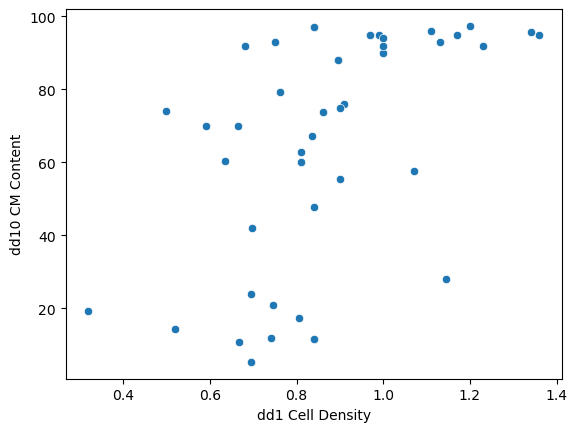

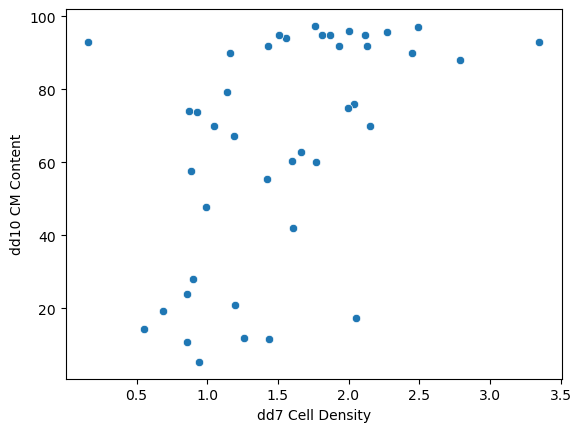

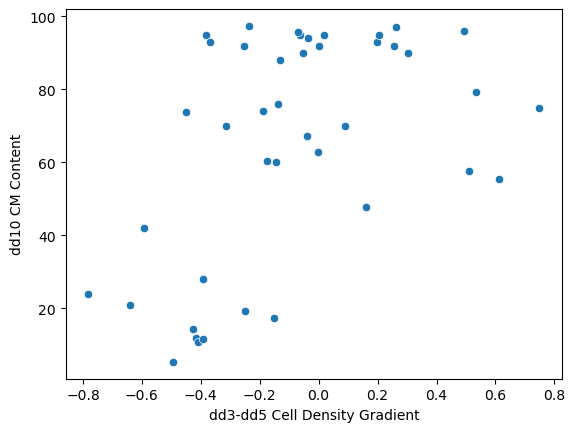

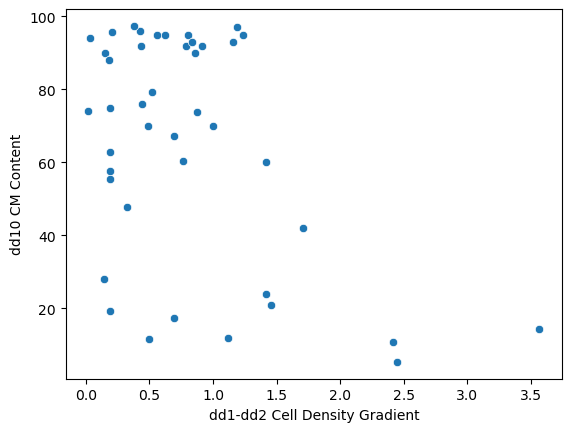

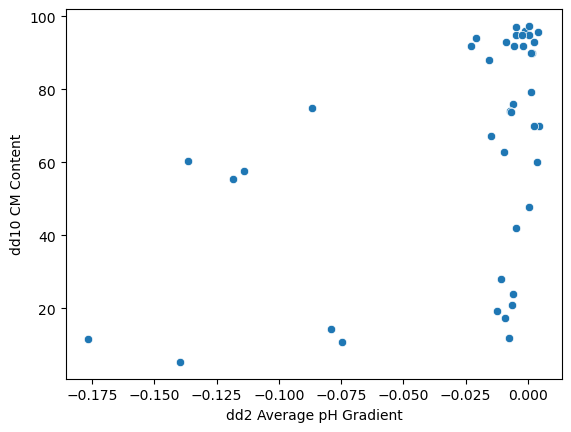

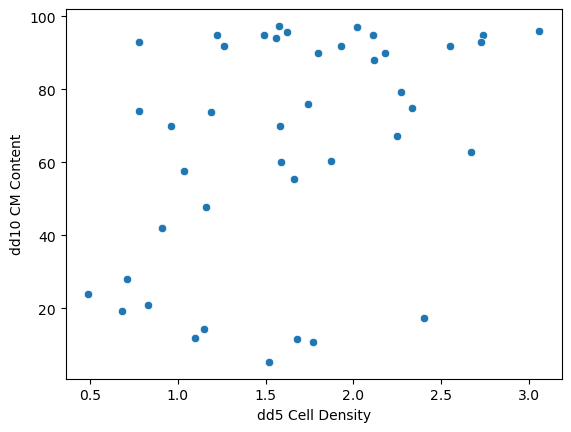

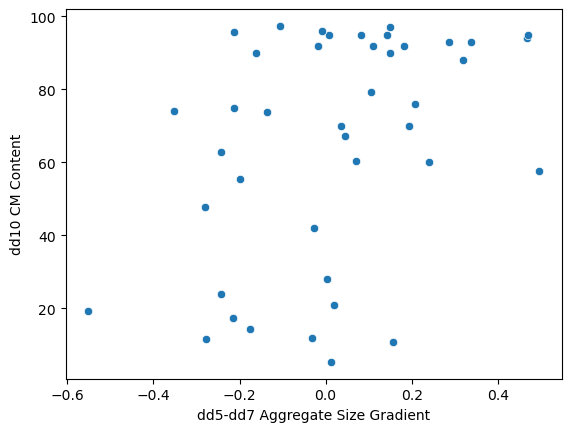

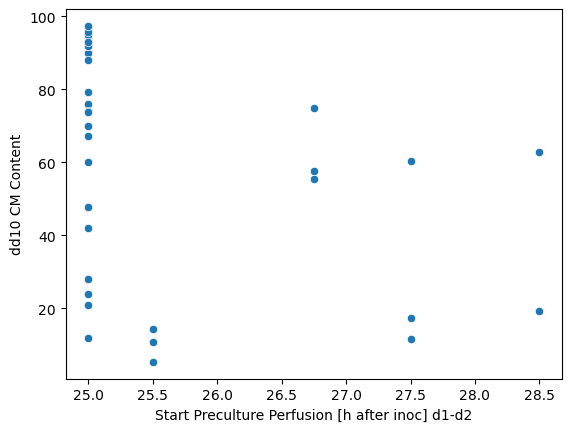

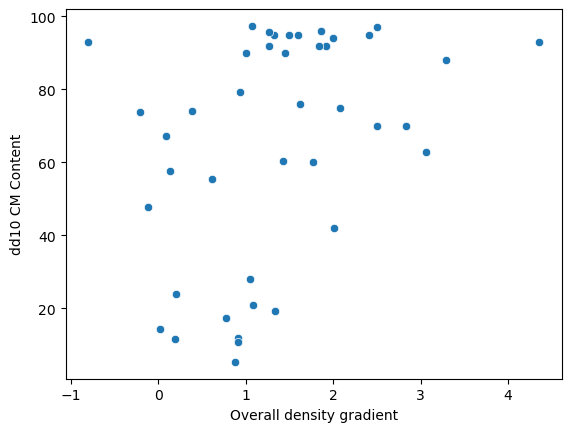

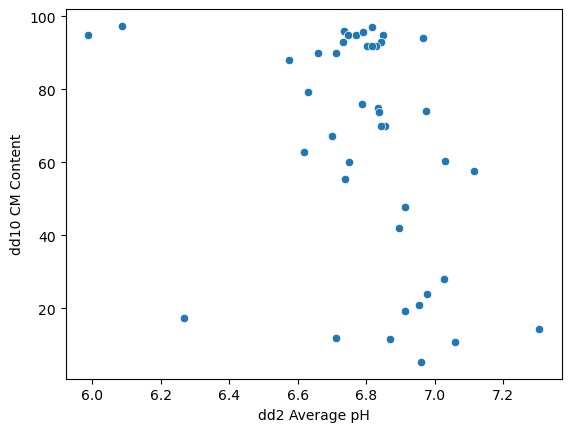

In [75]:
# Visualizing scatterplots between top 10 features and response variable
features = train_data.columns[:-1]
target = train_data.columns[-1]
for feature in features:
    sns.scatterplot(data=train_data, x=feature, y=target)
    plt.show()

/Users/graham/anaconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


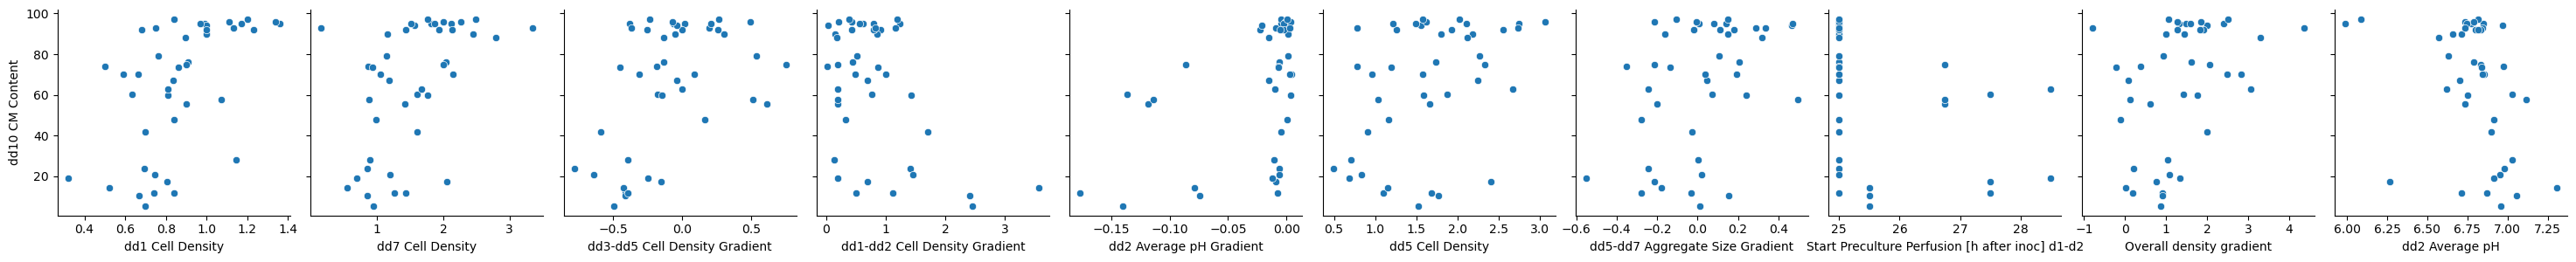

In [70]:
sns.pairplot(data=train_data, y_vars='dd10 CM Content', x_vars=train_data.columns[:-1], kind='scatter', height=3)
plt.show()

## Feature Scaling

Linear regression often performs better when the features have been scaled. It also helps ensure the regression coefficients area a reasonable size. The features will be standardized to give them a mean of 0 and unit variance

In [80]:
from sklearn.preprocessing import StandardScaler
standardize = StandardScaler()
X_scaled_feat = standardize.fit_transform(X_train_top10)
X_scaled_feat.shape

(42, 10)

## Model Fitting

Cross validation will be done using the training set.

In [94]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
# Converting y into numpy arrays
y_train = y_train.values
# Due to limited number of observations, only 3 splits will be done for cv
kf = KFold(n_splits=3, shuffle=True, random_state=25)
# Instantiating linreg model
linreg = LinearRegression()
# Cross validation using RMSE as scoring statistic
cv_results = -cross_val_score(linreg, X_scaled_feat, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_RMSE = cv_results ** 0.5
print("The RMSE scores for the 3 folds of CV are {} with a mean of {}".format(cv_RMSE, cv_RMSE.mean()))

The RMSE scores for the 3 folds of CV are [30.79476334 28.37122955 21.14665591] with a mean of 26.770882934843268


The variance between cv runs is very large. Let's try reducing the number of features to see if we get a better
fit. I'm thinking this won't work though as reducing features is usualy just for improving performance on unseen
data.

In [95]:
cv_results_r = cross_val_score(linreg, X_scaled_feat, y_train, cv=kf, scoring='r2')
cv_results

array([948.31744942, 804.9266664 , 447.18105603])

In [97]:
X_scaled_feat

array([[ 1.21942834e+00, -1.00312327e+00, -8.79904131e-01,
        -9.21834296e-01,  3.30693057e-01, -1.46216198e+00,
        -7.61694511e-02, -5.03346448e-01, -2.88800384e-01,
         9.92908974e-01],
       [-1.65125604e-01, -5.51306993e-01,  1.35021510e-01,
        -1.51872057e-01,  2.39045446e-01,  9.47147804e-01,
         1.12462767e-01, -5.03346448e-01, -1.22061319e+00,
        -3.94672499e-01],
       [ 1.33108592e+00,  4.14645050e-01,  6.70337190e-02,
        -2.50727078e-01,  5.74826373e-01,  7.28119642e-01,
        -5.66259871e-02, -5.03346448e-01, -2.00578514e-02,
         2.40056875e-01],
       [-7.90408030e-01, -1.07323269e+00, -1.99036118e+00,
         8.53834972e-01,  4.33228400e-01, -1.80634910e+00,
        -1.13582262e+00, -5.03346448e-01, -1.11071371e+00,
         7.86301050e-01],
       [ 1.25184094e-01, -1.92493277e-01,  1.99522385e+00,
        -8.57545869e-01, -2.00108289e+00,  2.41005478e-02,
        -9.52052287e-01,  1.23764009e+00, -7.10363695e-01,
        -2.

In [96]:
type(y_train)

numpy.ndarray